In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movies/sample_submission.csv
/kaggle/input/alx-movies/movies.csv
/kaggle/input/alx-movies/imdb_data.csv
/kaggle/input/alx-movies/genome_tags.csv
/kaggle/input/alx-movies/genome_scores.csv
/kaggle/input/alx-movies/train.csv
/kaggle/input/alx-movies/test.csv
/kaggle/input/alx-movies/tags.csv
/kaggle/input/alx-movies/links.csv


# ALX Movie Recommendation Project 2024
# 
# Introduction

In today’s technology-driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, we are challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences. Dataset Description

This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems. Files

genome_scores.csv: A score mapping the strength between movies and tag-related properties.

genome_tags.csv: User assigned tags for genome-related scores.

imdb_data.csv: Additional movie metadata scraped from IMDB using the links.csv file.

links.csv: File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.

movies.csv: Details about the movies

sample_submission.csv: Sample of the submission format for the hackathon.

tags.csv: User assigned for the movies within the dataset.

test.csv: The test split of the dataset. Contains user and movie IDs with no rating data.

train.csv: The training split of the dataset. Contains user and movie IDs with associated rating data.

Loading and Inspecting the Data



In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from math import sqrt

from collections import Counter
import operator  
import heapq
  
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load genome_tags.csv
genome_tags = pd.read_csv('/kaggle/input/alx-movies/genome_tags.csv')
print("\nGenome Tags:")
 

In [3]:
# Load movies.csv
movies = pd.read_csv('/kaggle/input/alx-movies/movies.csv')
print("\nMovies:")
 


Movies:


In [4]:
# Load imdb_data.csv
imdb_data = pd.read_csv('/kaggle/input/alx-movies/imdb_data.csv')
print("\nIMDB Data:")



IMDB Data:


In [5]:
# Load train.csv
train = pd.read_csv('/kaggle/input/alx-movies/train.csv')
print("\nTrain Data:")
 


Train Data:


In [6]:
# Load test.csv
test = pd.read_csv('/kaggle/input/alx-movies/test.csv')
print("\nTest Data:")
 


Test Data:


In [7]:
# Load sample_submission.csv
sample_submission = pd.read_csv('/kaggle/input/alx-movies/sample_submission.csv')
print("\nSample Submission:")
 


Sample Submission:


**1.1 Merge movies.csv with imdb_data.csv**

In [8]:
# Merge movies with IMDb data on movieId
movies_imdb = pd.merge(movies, imdb_data, on='movieId', how='left')

# Drop irrelevant columns
movies_imdb.drop(['title_cast', 'director', 'plot_keywords'], axis=1, inplace=True)

movies_imdb.head()

,movieId,title,genres,runtime,budget
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,81.0,"$30,000,000"
1,2,Jumanji (1995),Adventure|Children|Fantasy,104.0,"$65,000,000"
2,3,Grumpier Old Men (1995),Comedy|Romance,101.0,"$25,000,000"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,124.0,"$16,000,000"
4,5,Father of the Bride Part II (1995),Comedy,106.0,"$30,000,000"


**1.2 Merge train and test data with the merged movies_imdb**

In [9]:
# Merge train with movies_imdb on movieId
train_merged = pd.merge(train, movies_imdb, on='movieId', how='left')
train_merged.head()



,userId,movieId,rating,timestamp,title,genres,runtime,budget
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,107.0,"$15,000,000"
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,106.0,"$30,000,000"
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,88.0,"$140,000,000"
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,115.0,"$45,000,000"
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,112.0,"$8,000,000"


In [10]:
train_merged['timestamp'] = pd.to_datetime(train_merged['timestamp'], unit='s')
train_merged['year'] = train_merged['timestamp'].dt.year

In [11]:
# Merge test with movies_imdb on movieId
test_merged = pd.merge(test, movies_imdb, on='movieId', how='left')
test_merged

,userId,movieId,title,genres,runtime,budget
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN
1,1,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,98.0,NaN
2,1,5767,Teddy Bear (Mis) (1981),Comedy|Crime,NaN,NaN
3,1,6711,Lost in Translation (2003),Comedy|Drama|Romance,102.0,"$4,000,000"
4,1,7318,"Passion of the Christ, The (2004)",Drama,127.0,"$30,000,000"
...,...,...,...,...,...,...
5000014,162541,4079,Amazon Women on the Moon (1987),Comedy|Sci-Fi,NaN,NaN
5000015,162541,4467,"Adventures of Baron Munchausen, The (1988)",Adventure|Comedy|Fantasy,NaN,NaN
5000016,162541,4980,Bill & Ted's Bogus Journey (1991),Adventure|Comedy|Fantasy|Sci-Fi,93.0,"$20,000,000"
5000017,162541,5689,Billy Bathgate (1991),Crime|Drama,106.0,"$48,000,000"


In [13]:
sample_size = 0.2  # Example: reduce dataset to 50% of its original size
train_sample = train_merged.sample(frac=sample_size, random_state=42)
test_sample = test_merged.sample(frac=sample_size, random_state=42)


In [14]:
train_sample['budget'] = train_sample['budget'].str.replace('[^\d.]', '', regex=True).astype(float)  # Remove non-digit characters
test_sample['budget'] = test_sample['budget'].str.replace('[^\d.]', '', regex=True).astype(float)  # Remove non-digit characters


# Exploratory Data Analysis (EDA)

**We'll perform some EDA and feature engineering, such as one-hot encoding genres and scaling numerical features.**

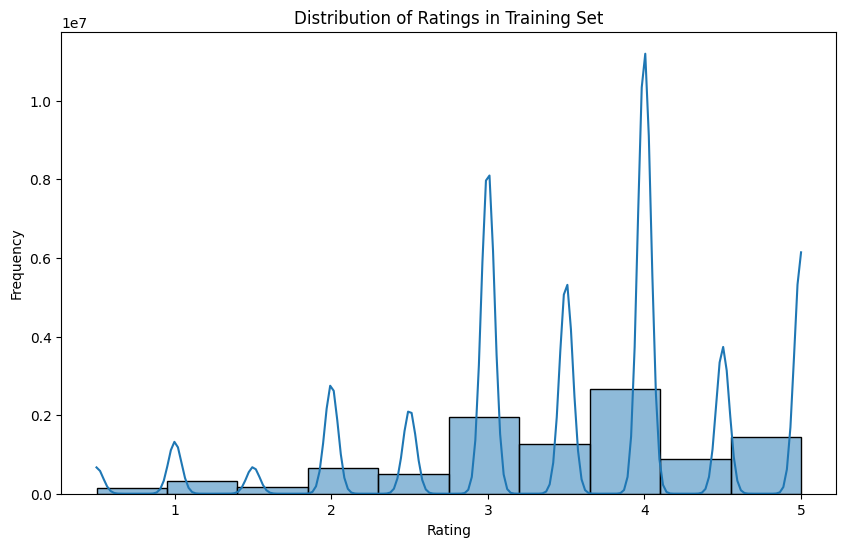

In [15]:
# Distribution of ratings in the training set
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings in Training Set')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant', fill_value=0)
train_sample[['runtime', 'budget']] = imputer.fit_transform(train_sample[['runtime', 'budget']])
test_sample[['runtime', 'budget']] = imputer.transform(test_sample[['runtime', 'budget']])

   
scaler = MinMaxScaler()
train_sample[['runtime', 'budget']] = scaler.fit_transform(train_sample[['runtime', 'budget']])
test_sample[['runtime', 'budget']] = scaler.transform(test_sample[['runtime', 'budget']])

train_sample.head()
test_sample.head()


,userId,movieId,rating,timestamp,title,genres,runtime,budget,year
5954604,122380,31445,2.5,2006-10-04 13:05:40,Employee of the Month (2004),Comedy|Drama,0.109589,0.000000,2006
1460784,22380,56775,4.0,2012-08-02 19:43:00,National Treasure: Book of Secrets (2007),Action|Adventure,0.140411,0.004333,2012
6631832,104339,356,2.5,2005-03-22 22:09:57,Forrest Gump (1994),Comedy|Drama|Romance|War,0.160959,0.001833,2005
5396407,64877,6874,4.0,2017-12-20 20:04:57,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,0.125571,0.001000,2017
8150654,63164,2762,5.0,2001-11-09 14:11:04,"Sixth Sense, The (1999)",Drama|Horror|Mystery,0.121005,0.001333,2001


# Building the Hybrid Recommendation Model

**We'll build both collaborative filtering and content-based filtering models.**

 Collaborative Filtering Model

In [20]:
train_sample.head()

,userId,movieId,rating,timestamp,title,genres,runtime,budget,year
5954604,122380,31445,2.5,2006-10-04 13:05:40,Employee of the Month (2004),Comedy|Drama,0.109589,0.000000,2006
1460784,22380,56775,4.0,2012-08-02 19:43:00,National Treasure: Book of Secrets (2007),Action|Adventure,0.140411,0.004333,2012
6631832,104339,356,2.5,2005-03-22 22:09:57,Forrest Gump (1994),Comedy|Drama|Romance|War,0.160959,0.001833,2005
5396407,64877,6874,4.0,2017-12-20 20:04:57,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,0.125571,0.001000,2017
8150654,63164,2762,5.0,2001-11-09 14:11:04,"Sixth Sense, The (1999)",Drama|Horror|Mystery,0.121005,0.001333,2001


In [ ]:
# Create a user-item matrix for collaborative filtering
user_item_matrix = train_merge.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_sparse = csr_matrix(user_item_matrix.values)

# Apply Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(user_item_sparse)
movie_factors = svd.components_.T

#print(user_factors.shape, movie_factors.shape)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),stop_words='english')
tfidf_matrix = tf.fit_transform(train_merged['title'])

In [ ]:
train_merged = train_merged.reset_index()
titles = train_merged['title']
indices = pd.Series(train_merged.index, index=train_merged['title'])

 Content-Based Filtering Model
 

In [ ]:
#train_merge

In [ ]:
 # Normalize movie features
movie_features_train = train_merge.drop(['userId', 'rating','movieId'], axis=1).values
movie_features_test = test_merge.drop(['userId', 'movieId'], axis=1).values

scaler = MinMaxScaler()
movie_features_train_scaled = scaler.fit_transform(movie_features_train)
movie_features_test_scaled = scaler.transform(movie_features_test)

#print(movie_features_train_scaled.shape, movie_features_test_scaled.shape)

# Hybrid Model
#
**Combine predictions from both models.**

In [ ]:
# Function to predict ratings using collaborative filtering
def predict_collaborative(user_id, movie_id):
    user_index = user_id - 1  # Assuming user IDs are 1-based
    movie_index = movie_id - 1  # Assuming movie IDs are 1-based
    return np.dot(user_factors[user_index], movie_factors[movie_index])

# Function to predict ratings using content-based filtering
def predict_content_based(user_id, movie_id):
    movie_index = train_merged[train_merged['movieId'] == movie_id].index[0]
    user_vector = movie_features_train_scaled[user_index]
    movie_vector = movie_features_train_scaled[movie_index]
    return np.dot(user_vector, movie_vector)

# Hybrid prediction function
def predict_hybrid(user_id, movie_id, alpha=0.5):
    pred_collaborative = predict_collaborative(user_id, movie_id)
    pred_content_based = predict_content_based(user_id, movie_id)
    return alpha * pred_collaborative + (1 - alpha) * pred_content_based

# Model Training, Validation, and Testing

In [ ]:
predictions = []
for _, row in test_merged.iterrows():
    predictions.append(predict_hybrid(row['userId'], row['movieId']))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_merged['rating'], predictions))
print(f'RMSE: {rmse}')